In [2]:
# Path of a Particle in Roche Potential

# ----- Libraries -----
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import brentq

### Other

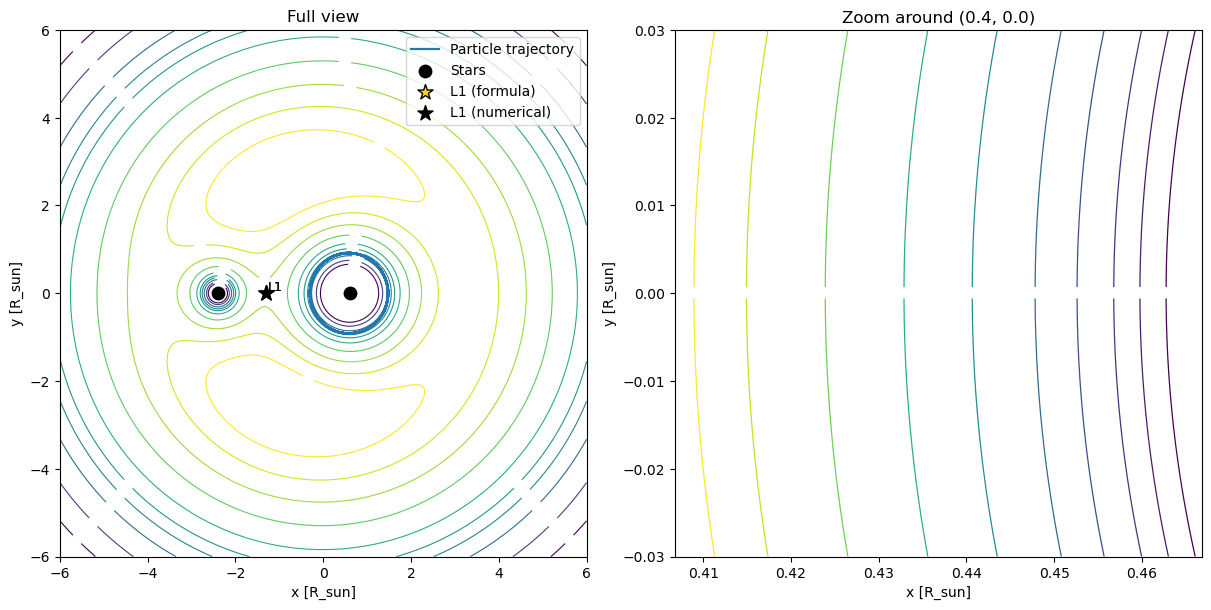

In [169]:
#region ----- Setup ------

# ----- Constants ------
G = 6.67430e-11          # [m^3 kg^-1 s^-2] gravitational constant
M_sun = 1.98847e30       # [kg] solar mass
R_sun = 6.957e8          # [m] solar radius

# ----- Model Parameters -----
M_c = 1.4 * M_sun        # [kg] accretor (e.g., neutron star)
M_s = 0.35 * M_sun       # [kg] donor star
a   = 3 * R_sun          # [m] separation between object centers

# ----- Positions of Stars in (Barycentric) Coordinate System -----

x_c =  a * M_s / (M_c + M_s)    # [m] accretor on right
y_c = 0.0                       # [m]
x_s = -a * M_c / (M_c + M_s)    # [m] donor on left
y_s = 0.0                       # [m]

r_c = np.array([x_c, y_c], dtype=float) # accretor position
r_s = np.array([x_s, y_s], dtype=float) # donor position  

# ----- Binary orbital angular speed -----
Omega = np.sqrt(G * (M_c + M_s) / a**3)    # [rad/s]
Period = 2.0 * np.pi / Omega               # [s] orbital period

#endregion

#region ------ Dynamics Functions ------

def accel_xy(x, y, vx, vy):

    """
    Provided the position (x,y) and velocity (vx,vy) of a test particle in the
    rotating frame, this function return the acceleration (ax,ay) in that frame.
    a = gravity(M_c) + gravity(M_s) + centrifugal + coriolis
    """
    
    # Dispacement components from stars to particle
    dx_c = x - r_c[0]
    dy_c = y - r_c[1]
    dx_s = x - r_s[0]
    dy_s = y - r_s[1]

    # Distances squared
    rc2 = dx_c*dx_c + dy_c*dy_c
    rs2 = dx_s*dx_s + dy_s*dy_s

    # Distances |r|^3
    rc32 = rc2 * np.sqrt(rc2)
    rs32 = rs2 * np.sqrt(rs2)

    # Gravity (per unit mass)
    ax_g = -G * M_c * dx_c / rc32 - G * M_s * dx_s / rs32
    ay_g = -G * M_c * dy_c / rc32 - G * M_s * dy_s / rs32

    # Centrifugal (about CM at origin)
    ax_cent = Omega * Omega * x
    ay_cent = Omega * Omega * y

    # Coriolis
    ax_cor =  2.0 * Omega * vy
    ay_cor = -2.0 * Omega * vx

    # Acceleration components
    ax = ax_g + ax_cent + ax_cor
    ay = ay_g + ay_cent + ay_cor
    
    return ax, ay

def time_derivative(state):
    """
    Returns the time derivatives [dx/dt, dy/dt, dvx/dt, dvy/dt]
    for a particle in the rotating frame, given its current state.
    
    state = [x, y, vx, vy]
    """
    # Unpack state vector
    x, y, vx, vy = state
    
    # Compute accelerations from forces
    ax, ay = accel_xy(x, y, vx, vy)
    
    # Return the derivative of the state
    return np.array([vx, vy, ax, ay], dtype=float)

def rk4_step(state, dt):
    """
    Perform a single 4th-order Runge–Kutta integration step.
    
    state = [x, y, vx, vy]
    dt    = timestep
    """
    # Evaluate intermediate slopes
    k1 = time_derivative(state)
    k2 = time_derivative(state + 0.5 * dt * k1)
    k3 = time_derivative(state + 0.5 * dt * k2)
    k4 = time_derivative(state + dt * k3)
    
    # Return the updated state (fourth-order accurate)
    new_state = state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return new_state
#endregion

#region ----- Fizix Functions -----

def roche_potential(x, y, eps=1e2):
    
    # Dispacement components from stars to particle
    dx_c = x - r_c[0]
    dy_c = y - r_c[1]
    dx_s = x - r_s[0]
    dy_s = y - r_s[1]

    # Distances with softening to avoid singularities
    rc = np.sqrt(dx_c*dx_c + dy_c*dy_c + eps*eps)
    rs = np.sqrt(dx_s*dx_s + dy_s*dy_s + eps*eps)

    # Roche potential
    roche_potential = -G*M_c/rc - G*M_s/rs - 0.5 * (Omega**2) * (x*x + y*y)
    
    return roche_potential

def l1_from_formula(x_c, x_s, a, M_c, M_s, use_log10=True):
    q = M_c / M_s                          # (donor / compact)
    logq = np.log10(q) if use_log10 else np.log(q)
    b1 = a * (0.500 + 0.227 * logq)        # distance from compact star to L1
    # put L1 along the line from compact star toward the donor
    dir_sign = np.sign(x_s - x_c)          # +1 if donor to the right, -1 if to the left
    x_L1 = x_c + dir_sign * b1
    y_L1 = 0.0                             # your stars lie on y=0
    return x_L1, y_L1

def dPhi_dx(x, eps=1e2):
    """Derivative of Roche potential along x-axis (y=0)."""
    dx_c = x - r_c[0]
    dx_s = x - r_s[0]
    rc3 = (dx_c**2 + eps**2)**1.5
    rs3 = (dx_s**2 + eps**2)**1.5
    # derivative of effective potential wrt x
    return G*M_c*dx_c/rc3 + G*M_s*dx_s/rs3 - Omega**2 * x
#endregion

# Mark L1 point (from formula) AND then from numerical root finding
x_L1f, y_L1f = l1_from_formula(x_c, x_s, a, M_c, M_s, use_log10=True)
x_L1n, y_L1n = brentq(dPhi_dx, r_c[0], r_s[0]), 0

# ----- Initial Conditions -----

x0 = x_c - 0.3 * a     # [m]                                          *******************************************************************
y0 = 0.0                # [m]
vx0 = 0.0               # [m/s]
vy0 = -4.5e5          # [m/s]                                         *******************************************************************

state0 = np.array([x0, y0, vx0, vy0], dtype=float)

# ----- Integration Controls -----

dt = 2             # [s] #                                              *******************************************************************
Nsteps = int(2.8e5)  # total steps #                                    *******************************************************************
only_1_orbit = False

#region ----- Integrator -----

traj = np.empty((Nsteps, 4), dtype=float) # to store trajectory
state = state0.copy()
crossed_x_axis = 0
prev_y_sgn = np.sign(state[1])

cross_coords = []

i = 0
while i < Nsteps:
    
    traj[i] = state
    cur_y_sgn = np.sign(state[1])

    # Stop if particle gets too close to accretor
    dx, dy = state[0] - x_c, state[1] - y_c
    if np.hypot(dx, dy) < 0.04 * a: # [m] Radius threshold
        traj = traj[:i+1]
        break
    if only_1_orbit:
        if prev_y_sgn != cur_y_sgn:
            crossed_x_axis += 1
            cross_coords.append(state)
        if crossed_x_axis >= 3:
            break

    state = rk4_step(state, dt)
    prev_y_sgn = cur_y_sgn
    i += 1

if i < Nsteps:
    traj = traj[:i]

x_traj, y_traj, vx_traj, vy_traj = traj.T
#endregion

#region ----- Plotting -----

# Grid
size = 4 * a
nx = ny = 400
xs = np.linspace(-size*0.5, size*0.5, nx)
ys = np.linspace(-size*0.5, size*0.5, ny)
XX, YY = np.meshgrid(xs, ys)

# Plotting equipotentials
Phi_grid = roche_potential(XX, YY)
levels_full = np.quantile(Phi_grid, [0.02, 0.05, 0.10, 0.15, 0.20, 0.30, 0.45, 0.60, 0.75, 0.90])

# Grid for zoomed view
zoom_x_cent = x_traj[-1] # x0
zoom_y_cent = y0 # y_traj[-1] # y0
zoom = 0.01 * a  #                                           *******************************************************************
displacement = 0.0 * a #                                    *******************************************************************
nxz = nyz = 500
xsz = np.linspace(zoom_x_cent + displacement - zoom, zoom_x_cent + displacement + zoom, nxz)
# xsz = np.linspace(x_c + displacement - zoom, x_c + displacement + zoom, nxz)
ysz = np.linspace(zoom_y_cent - zoom, zoom_y_cent + zoom, nyz)
# ysz = np.linspace(y_c - zoom, y_c + zoom, nyz)
XXz, YYz = np.meshgrid(xsz, ysz)

# Plotting equipotentials in zoomed view
Phi_grid_z = roche_potential(XXz, YYz)
levels_zoom = np.quantile(Phi_grid_z, [0.05, 0.10, 0.15, 0.22, 0.30, 0.42, 0.55, 0.70, 0.85, 0.95])

# Make Figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Left: full view
cs1 = ax1.contour(XX/R_sun, YY/R_sun, Phi_grid, levels=levels_full, linewidths=0.8)
ax1.clabel(cs1, inline=True, fontsize=7, fmt="")
ax1.plot(x_traj/R_sun, y_traj/R_sun, lw=1.6, label='Particle trajectory')
ax1.scatter([x_c/R_sun, x_s/R_sun], [y_c/R_sun, y_s/R_sun], s=80, c='k', marker='o', label='Stars')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x [R_sun]')
ax1.set_ylabel('y [R_sun]')
ax1.set_title('Full view')
ax1.legend(loc='upper right', frameon=True)
ax1.set_xlim(-size*0.5/R_sun, size*0.5/R_sun)
ax1.set_ylim(-size*0.5/R_sun, size*0.5/R_sun)

ax1.scatter(x_L1f/R_sun, y_L1f/R_sun, s=130, c='gold', marker='*', edgecolor='k', zorder=5, label='L1 (formula)')
ax1.text(x_L1f/R_sun + 0.05, y_L1f/R_sun + 0.05, 'L1', color='k', fontsize=9)
ax1.legend(loc='upper right', frameon=True)

ax1.scatter(x_L1n/R_sun, y_L1n/R_sun, s=130, c='black', marker='*', edgecolor='k', zorder=5, label='L1 (numerical)')
ax1.text(x_L1n/R_sun + 0.05, y_L1n/R_sun + 0.05, 'L1', color='k', fontsize=9)
ax1.legend(loc='upper right', frameon=True)

# Right: zoom on accretor
cs2 = ax2.contour(XXz/R_sun, YYz/R_sun, Phi_grid_z, levels=levels_zoom, linewidths=0.9)
ax2.clabel(cs2, inline=True, fontsize=7, fmt="")
ax2.plot(x_traj/R_sun, y_traj/R_sun, lw=1.6)
ax2.scatter([x_c/R_sun], [y_c/R_sun], s=90, c='k', marker='o')
ax2.set_aspect('equal', 'box')
ax2.set_xlabel('x [R_sun]')
ax2.set_ylabel('y [R_sun]')
# ax2.set_title('Zoom around accretor')
ax2.set_title(f'Zoom around ({zoom_x_cent/R_sun:.1f}, {zoom_y_cent/R_sun:.1f})')
# x_center = x_c + displacement
x_center = zoom_x_cent + displacement
ax2.set_xlim((x_center - zoom)/R_sun, (x_center + zoom)/R_sun)
ax2.set_ylim((y_c - zoom)/R_sun, (y_c + zoom)/R_sun)

if only_1_orbit:
    cross_coords_plt = np.array(cross_coords)[:,:2] / R_sun
    ax1.scatter(cross_coords_plt[:,0], cross_coords_plt[:,1], s=50, c="purple")
    ax2.scatter(cross_coords_plt[:,0], cross_coords_plt[:,1], s=10, c="purple")
plt.show()
#endregion


### Stable orbit around entire system

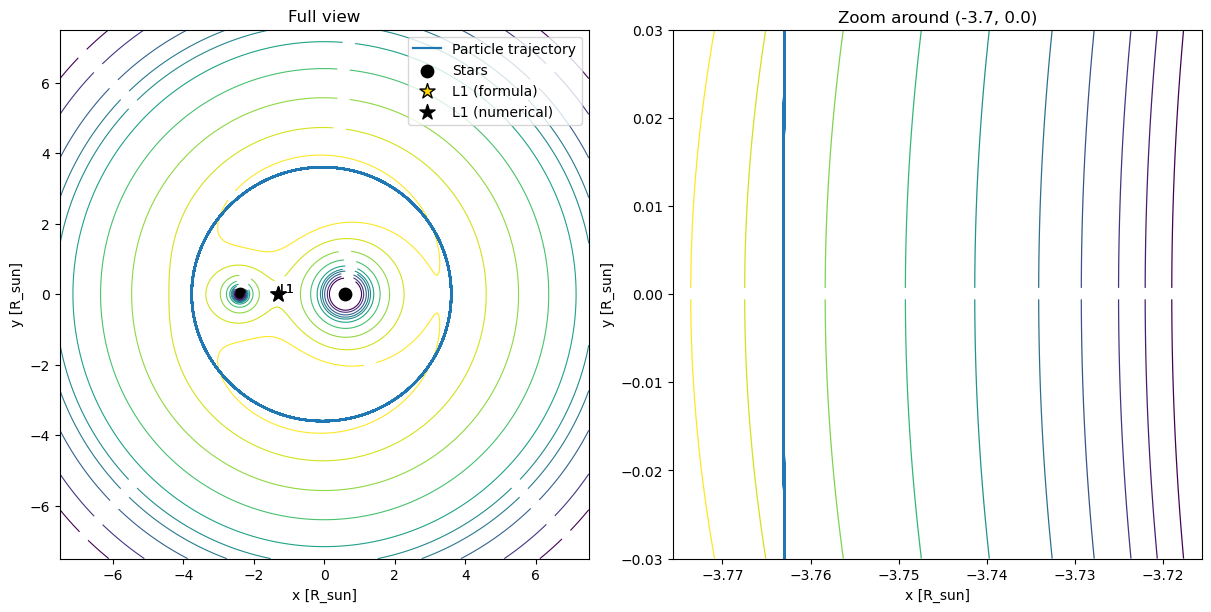

In [159]:
#region ----- Setup ------

# ----- Constants ------
G = 6.67430e-11          # [m^3 kg^-1 s^-2] gravitational constant
M_sun = 1.98847e30       # [kg] solar mass
R_sun = 6.957e8          # [m] solar radius

# ----- Model Parameters -----
M_c = 1.4 * M_sun        # [kg] accretor (e.g., neutron star)
M_s = 0.35 * M_sun       # [kg] donor star
a   = 3 * R_sun          # [m] separation between object centers

# ----- Positions of Stars in (Barycentric) Coordinate System -----

x_c =  a * M_s / (M_c + M_s)    # [m] accretor on right
y_c = 0.0                       # [m]
x_s = -a * M_c / (M_c + M_s)    # [m] donor on left
y_s = 0.0                       # [m]

r_c = np.array([x_c, y_c], dtype=float) # accretor position
r_s = np.array([x_s, y_s], dtype=float) # donor position  

# ----- Binary orbital angular speed -----
Omega = np.sqrt(G * (M_c + M_s) / a**3)    # [rad/s]
Period = 2.0 * np.pi / Omega               # [s] orbital period

#endregion

#region ------ Dynamics Functions ------

def accel_xy(x, y, vx, vy):

    """
    Provided the position (x,y) and velocity (vx,vy) of a test particle in the
    rotating frame, this function return the acceleration (ax,ay) in that frame.
    a = gravity(M_c) + gravity(M_s) + centrifugal + coriolis
    """
    
    # Dispacement components from stars to particle
    dx_c = x - r_c[0]
    dy_c = y - r_c[1]
    dx_s = x - r_s[0]
    dy_s = y - r_s[1]

    # Distances squared
    rc2 = dx_c*dx_c + dy_c*dy_c
    rs2 = dx_s*dx_s + dy_s*dy_s

    # Distances |r|^3
    rc32 = rc2 * np.sqrt(rc2)
    rs32 = rs2 * np.sqrt(rs2)

    # Gravity (per unit mass)
    ax_g = -G * M_c * dx_c / rc32 - G * M_s * dx_s / rs32
    ay_g = -G * M_c * dy_c / rc32 - G * M_s * dy_s / rs32

    # Centrifugal (about CM at origin)
    ax_cent = Omega * Omega * x
    ay_cent = Omega * Omega * y

    # Coriolis
    ax_cor =  2.0 * Omega * vy
    ay_cor = -2.0 * Omega * vx

    # Acceleration components
    ax = ax_g + ax_cent + ax_cor
    ay = ay_g + ay_cent + ay_cor
    
    return ax, ay

def time_derivative(state):
    """
    Returns the time derivatives [dx/dt, dy/dt, dvx/dt, dvy/dt]
    for a particle in the rotating frame, given its current state.
    
    state = [x, y, vx, vy]
    """
    # Unpack state vector
    x, y, vx, vy = state
    
    # Compute accelerations from forces
    ax, ay = accel_xy(x, y, vx, vy)
    
    # Return the derivative of the state
    return np.array([vx, vy, ax, ay], dtype=float)

def rk4_step(state, dt):
    """
    Perform a single 4th-order Runge–Kutta integration step.
    
    state = [x, y, vx, vy]
    dt    = timestep
    """
    # Evaluate intermediate slopes
    k1 = time_derivative(state)
    k2 = time_derivative(state + 0.5 * dt * k1)
    k3 = time_derivative(state + 0.5 * dt * k2)
    k4 = time_derivative(state + dt * k3)
    
    # Return the updated state (fourth-order accurate)
    new_state = state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return new_state
#endregion

#region ----- Fizix Functions -----

def roche_potential(x, y, eps=1e2):
    
    # Dispacement components from stars to particle
    dx_c = x - r_c[0]
    dy_c = y - r_c[1]
    dx_s = x - r_s[0]
    dy_s = y - r_s[1]

    # Distances with softening to avoid singularities
    rc = np.sqrt(dx_c*dx_c + dy_c*dy_c + eps*eps)
    rs = np.sqrt(dx_s*dx_s + dy_s*dy_s + eps*eps)

    # Roche potential
    roche_potential = -G*M_c/rc - G*M_s/rs - 0.5 * (Omega**2) * (x*x + y*y)
    
    return roche_potential

def l1_from_formula(x_c, x_s, a, M_c, M_s, use_log10=True):
    q = M_c / M_s                          # (donor / compact)
    logq = np.log10(q) if use_log10 else np.log(q)
    b1 = a * (0.500 + 0.227 * logq)        # distance from compact star to L1
    # put L1 along the line from compact star toward the donor
    dir_sign = np.sign(x_s - x_c)          # +1 if donor to the right, -1 if to the left
    x_L1 = x_c + dir_sign * b1
    y_L1 = 0.0                             # your stars lie on y=0
    return x_L1, y_L1

def dPhi_dx(x, eps=1e2):
    """Derivative of Roche potential along x-axis (y=0)."""
    dx_c = x - r_c[0]
    dx_s = x - r_s[0]
    rc3 = (dx_c**2 + eps**2)**1.5
    rs3 = (dx_s**2 + eps**2)**1.5
    # derivative of effective potential wrt x
    return G*M_c*dx_c/rc3 + G*M_s*dx_s/rs3 - Omega**2 * x
#endregion

# Mark L1 point (from formula) AND then from numerical root finding
x_L1f, y_L1f = l1_from_formula(x_c, x_s, a, M_c, M_s, use_log10=True)
x_L1n, y_L1n = brentq(dPhi_dx, r_c[0], r_s[0]), 0

# ----- Initial Conditions -----

x0 = x_c + 1 * a     # [m]                                          *******************************************************************
y0 = 0.0                # [m]
vx0 = 0.0               # [m/s]
vy0 = -7.2895293e5          # [m/s]                                         *******************************************************************

state0 = np.array([x0, y0, vx0, vy0], dtype=float)

# ----- Integration Controls -----

dt = 2             # [s] #                                              *******************************************************************
Nsteps = int(2.8e5)  # total steps #                                    *******************************************************************
only_1_orbit = False

#region ----- Integrator -----

traj = np.empty((Nsteps, 4), dtype=float) # to store trajectory
state = state0.copy()
crossed_x_axis = 0
prev_y_sgn = np.sign(state[1])

cross_coords = []

i = 0
while i < Nsteps:
    
    traj[i] = state
    cur_y_sgn = np.sign(state[1])

    # Stop if particle gets too close to accretor
    dx, dy = state[0] - x_c, state[1] - y_c
    if np.hypot(dx, dy) < 0.04 * a: # [m] Radius threshold
        traj = traj[:i+1]
        break
    if only_1_orbit:
        if prev_y_sgn != cur_y_sgn:
            crossed_x_axis += 1
            cross_coords.append(state)
        if crossed_x_axis >= 3:
            break

    state = rk4_step(state, dt)
    prev_y_sgn = cur_y_sgn
    i += 1

if i < Nsteps:
    traj = traj[:i]

x_traj, y_traj, vx_traj, vy_traj = traj.T
#endregion

#region ----- Plotting -----

# Grid
size = 5 * a
nx = ny = 400
xs = np.linspace(-size*0.5, size*0.5, nx)
ys = np.linspace(-size*0.5, size*0.5, ny)
XX, YY = np.meshgrid(xs, ys)

# Plotting equipotentials
Phi_grid = roche_potential(XX, YY)
levels_full = np.quantile(Phi_grid, [0.02, 0.05, 0.10, 0.15, 0.20, 0.30, 0.45, 0.60, 0.75, 0.90])

# Grid for zoomed view
zoom_x_cent = x_traj[-1] # x0
zoom_y_cent = y0 # y_traj[-1] # y0
zoom = 0.01 * a  #                                           *******************************************************************
displacement = 0.0 * a #                                    *******************************************************************
nxz = nyz = 500
xsz = np.linspace(zoom_x_cent + displacement - zoom, zoom_x_cent + displacement + zoom, nxz)
# xsz = np.linspace(x_c + displacement - zoom, x_c + displacement + zoom, nxz)
ysz = np.linspace(zoom_y_cent - zoom, zoom_y_cent + zoom, nyz)
# ysz = np.linspace(y_c - zoom, y_c + zoom, nyz)
XXz, YYz = np.meshgrid(xsz, ysz)

# Plotting equipotentials in zoomed view
Phi_grid_z = roche_potential(XXz, YYz)
levels_zoom = np.quantile(Phi_grid_z, [0.05, 0.10, 0.15, 0.22, 0.30, 0.42, 0.55, 0.70, 0.85, 0.95])

# Make Figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Left: full view
cs1 = ax1.contour(XX/R_sun, YY/R_sun, Phi_grid, levels=levels_full, linewidths=0.8)
ax1.clabel(cs1, inline=True, fontsize=7, fmt="")
ax1.plot(x_traj/R_sun, y_traj/R_sun, lw=1.6, label='Particle trajectory')
ax1.scatter([x_c/R_sun, x_s/R_sun], [y_c/R_sun, y_s/R_sun], s=80, c='k', marker='o', label='Stars')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x [R_sun]')
ax1.set_ylabel('y [R_sun]')
ax1.set_title('Full view')
ax1.legend(loc='upper right', frameon=True)
ax1.set_xlim(-size*0.5/R_sun, size*0.5/R_sun)
ax1.set_ylim(-size*0.5/R_sun, size*0.5/R_sun)

ax1.scatter(x_L1f/R_sun, y_L1f/R_sun, s=130, c='gold', marker='*', edgecolor='k', zorder=5, label='L1 (formula)')
ax1.text(x_L1f/R_sun + 0.05, y_L1f/R_sun + 0.05, 'L1', color='k', fontsize=9)
ax1.legend(loc='upper right', frameon=True)

ax1.scatter(x_L1n/R_sun, y_L1n/R_sun, s=130, c='black', marker='*', edgecolor='k', zorder=5, label='L1 (numerical)')
ax1.text(x_L1n/R_sun + 0.05, y_L1n/R_sun + 0.05, 'L1', color='k', fontsize=9)
ax1.legend(loc='upper right', frameon=True)

# Right: zoom on accretor
cs2 = ax2.contour(XXz/R_sun, YYz/R_sun, Phi_grid_z, levels=levels_zoom, linewidths=0.9)
ax2.clabel(cs2, inline=True, fontsize=7, fmt="")
ax2.plot(x_traj/R_sun, y_traj/R_sun, lw=1.6)
ax2.scatter([x_c/R_sun], [y_c/R_sun], s=90, c='k', marker='o')
ax2.set_aspect('equal', 'box')
ax2.set_xlabel('x [R_sun]')
ax2.set_ylabel('y [R_sun]')
# ax2.set_title('Zoom around accretor')
ax2.set_title(f'Zoom around ({zoom_x_cent/R_sun:.1f}, {zoom_y_cent/R_sun:.1f})')
# x_center = x_c + displacement
x_center = zoom_x_cent + displacement
ax2.set_xlim((x_center - zoom)/R_sun, (x_center + zoom)/R_sun)
ax2.set_ylim((y_c - zoom)/R_sun, (y_c + zoom)/R_sun)

if only_1_orbit:
    cross_coords_plt = np.array(cross_coords)[:,:2] / R_sun
    ax1.scatter(cross_coords_plt[:,0], cross_coords_plt[:,1], s=50, c="purple")
    ax2.scatter(cross_coords_plt[:,0], cross_coords_plt[:,1], s=10, c="purple")
plt.show()
#endregion


### Stable orbit through $L_1$ around copmact accretor

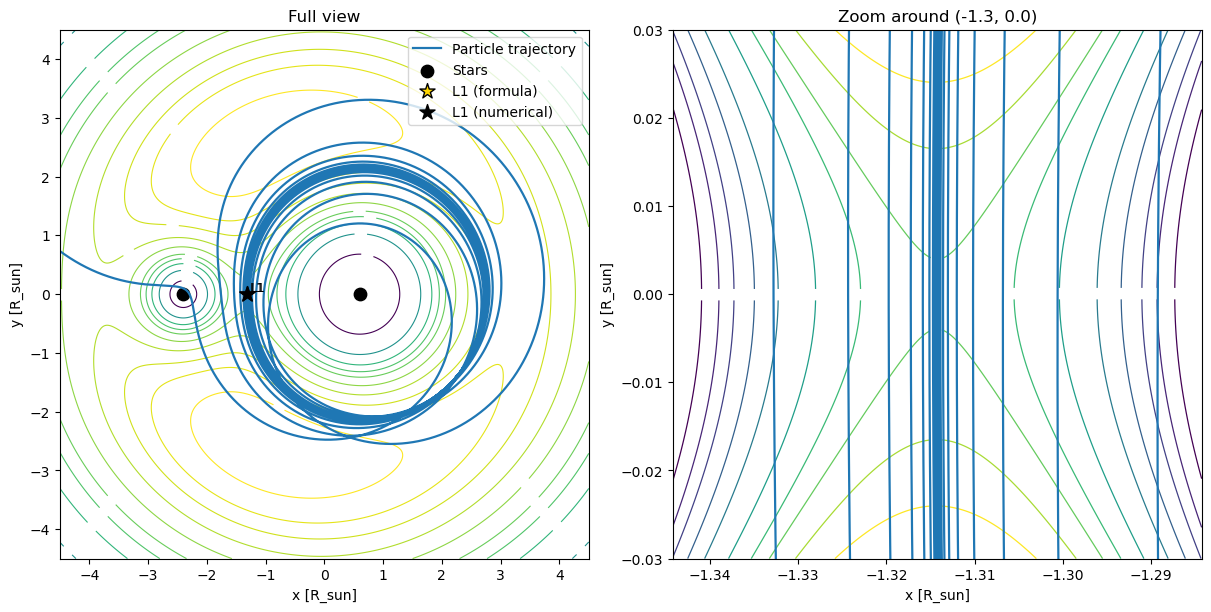

In [4]:
#region ----- Setup ------

# ----- Constants ------
G = 6.67430e-11          # [m^3 kg^-1 s^-2] gravitational constant
M_sun = 1.98847e30       # [kg] solar mass
R_sun = 6.957e8          # [m] solar radius

# ----- Model Parameters -----
M_c = 1.4 * M_sun        # [kg] accretor (e.g., neutron star)
M_s = 0.35 * M_sun       # [kg] donor star
a   = 3 * R_sun          # [m] separation between object centers

# ----- Positions of Stars in (Barycentric) Coordinate System -----

x_c =  a * M_s / (M_c + M_s)    # [m] accretor on right
y_c = 0.0                       # [m]
x_s = -a * M_c / (M_c + M_s)    # [m] donor on left
y_s = 0.0                       # [m]

r_c = np.array([x_c, y_c], dtype=float) # accretor position
r_s = np.array([x_s, y_s], dtype=float) # donor position  

# ----- Binary orbital angular speed -----
Omega = np.sqrt(G * (M_c + M_s) / a**3)    # [rad/s]
Period = 2.0 * np.pi / Omega               # [s] orbital period

#endregion

#region ------ Dynamics Functions ------

def accel_xy(x, y, vx, vy):

    """
    Provided the position (x,y) and velocity (vx,vy) of a test particle in the
    rotating frame, this function return the acceleration (ax,ay) in that frame.
    a = gravity(M_c) + gravity(M_s) + centrifugal + coriolis
    """
    
    # Dispacement components from stars to particle
    dx_c = x - r_c[0]
    dy_c = y - r_c[1]
    dx_s = x - r_s[0]
    dy_s = y - r_s[1]

    # Distances squared
    rc2 = dx_c*dx_c + dy_c*dy_c
    rs2 = dx_s*dx_s + dy_s*dy_s

    # Distances |r|^3
    rc32 = rc2 * np.sqrt(rc2)
    rs32 = rs2 * np.sqrt(rs2)

    # Gravity (per unit mass)
    ax_g = -G * M_c * dx_c / rc32 - G * M_s * dx_s / rs32
    ay_g = -G * M_c * dy_c / rc32 - G * M_s * dy_s / rs32

    # Centrifugal (about CM at origin)
    ax_cent = Omega * Omega * x
    ay_cent = Omega * Omega * y

    # Coriolis
    ax_cor =  2.0 * Omega * vy
    ay_cor = -2.0 * Omega * vx

    # Acceleration components
    ax = ax_g + ax_cent + ax_cor
    ay = ay_g + ay_cent + ay_cor
    
    return ax, ay

def time_derivative(state):
    """
    Returns the time derivatives [dx/dt, dy/dt, dvx/dt, dvy/dt]
    for a particle in the rotating frame, given its current state.
    
    state = [x, y, vx, vy]
    """
    # Unpack state vector
    x, y, vx, vy = state
    
    # Compute accelerations from forces
    ax, ay = accel_xy(x, y, vx, vy)
    
    # Return the derivative of the state
    return np.array([vx, vy, ax, ay], dtype=float)

def rk4_step(state, dt):
    """
    Perform a single 4th-order Runge–Kutta integration step.
    
    state = [x, y, vx, vy]
    dt    = timestep
    """
    # Evaluate intermediate slopes
    k1 = time_derivative(state)
    k2 = time_derivative(state + 0.5 * dt * k1)
    k3 = time_derivative(state + 0.5 * dt * k2)
    k4 = time_derivative(state + dt * k3)
    
    # Return the updated state (fourth-order accurate)
    new_state = state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return new_state
#endregion

#region ----- Fizix Functions -----

def roche_potential(x, y, eps=1e2):
    
    # Dispacement components from stars to particle
    dx_c = x - r_c[0]
    dy_c = y - r_c[1]
    dx_s = x - r_s[0]
    dy_s = y - r_s[1]

    # Distances with softening to avoid singularities
    rc = np.sqrt(dx_c*dx_c + dy_c*dy_c + eps*eps)
    rs = np.sqrt(dx_s*dx_s + dy_s*dy_s + eps*eps)

    # Roche potential
    roche_potential = -G*M_c/rc - G*M_s/rs - 0.5 * (Omega**2) * (x*x + y*y)
    
    return roche_potential

def l1_from_formula(x_c, x_s, a, M_c, M_s, use_log10=True):
    q = M_c / M_s                          # (donor / compact)
    logq = np.log10(q) if use_log10 else np.log(q)
    b1 = a * (0.500 + 0.227 * logq)        # distance from compact star to L1
    # put L1 along the line from compact star toward the donor
    dir_sign = np.sign(x_s - x_c)          # +1 if donor to the right, -1 if to the left
    x_L1 = x_c + dir_sign * b1
    y_L1 = 0.0                             # your stars lie on y=0
    return x_L1, y_L1

def dPhi_dx(x, eps=1e2):
    """Derivative of Roche potential along x-axis (y=0)."""
    dx_c = x - r_c[0]
    dx_s = x - r_s[0]
    rc3 = (dx_c**2 + eps**2)**1.5
    rs3 = (dx_s**2 + eps**2)**1.5
    # derivative of effective potential wrt x
    return G*M_c*dx_c/rc3 + G*M_s*dx_s/rs3 - Omega**2 * x
#endregion

# Mark L1 point (from formula) AND then from numerical root finding
x_L1f, y_L1f = l1_from_formula(x_c, x_s, a, M_c, M_s, use_log10=True)
x_L1n, y_L1n = brentq(dPhi_dx, r_c[0], r_s[0]), 0

# ----- Initial Conditions -----

# x0 = x_c - 0.93 * a     # [m]                                          *******************************************************************
x0 = x_L1n + 0.00*a             # [m]                                           *******************************************************************
y0 = 0.0                # [m]
vx0 = 0.0               # [m/s]
vy0 = +6.2907625e5          # [m/s]                                         *******************************************************************

state0 = np.array([x0, y0, vx0, vy0], dtype=float)

# ----- Integration Controls -----

dt = 2             # [s] #                                              *******************************************************************
Nsteps = int(2.8e6)  # total steps #                                    *******************************************************************
only_1_orbit = False

#region ----- Integrator -----

traj = np.empty((Nsteps, 4), dtype=float) # to store trajectory
state = state0.copy()
crossed_x_axis = 0
prev_y_sgn = np.sign(state[1])

cross_coords = []

i = 0
while i < Nsteps:
    
    traj[i] = state
    cur_y_sgn = np.sign(state[1])

    # Stop if particle gets too close to accretor
    dx, dy = state[0] - x_c, state[1] - y_c
    if np.hypot(dx, dy) < 0.04 * a: # [m] Radius threshold
        traj = traj[:i+1]
        break
    if only_1_orbit:
        if prev_y_sgn != cur_y_sgn:
            crossed_x_axis += 1
            cross_coords.append(state)
        if crossed_x_axis >= 4:
            break

    state = rk4_step(state, dt)
    prev_y_sgn = cur_y_sgn
    i += 1

if i < Nsteps:
    traj = traj[:i]

x_traj, y_traj, vx_traj, vy_traj = traj.T
#endregion

#region ----- Plotting -----

# Grid
size = 3 * a
nx = ny = 400
xs = np.linspace(-size*0.5, size*0.5, nx)
ys = np.linspace(-size*0.5, size*0.5, ny)
XX, YY = np.meshgrid(xs, ys)

# Plotting equipotentials
Phi_grid = roche_potential(XX, YY)
levels_full = np.quantile(Phi_grid, [0.02, 0.05, 0.10, 0.15, 0.20, 0.30, 0.45, 0.60, 0.75, 0.90])

# Grid for zoomed view
zoom_x_cent = x0 # x_traj[-1]
zoom_y_cent = y0 # y_traj[-1]
zoom = 0.01 * a  #                                           *******************************************************************
displacement = 0.0 * a #                                    *******************************************************************
nxz = nyz = 500
xsz = np.linspace(zoom_x_cent + displacement - zoom, zoom_x_cent + displacement + zoom, nxz)
# xsz = np.linspace(x_c + displacement - zoom, x_c + displacement + zoom, nxz)
ysz = np.linspace(zoom_y_cent - zoom, zoom_y_cent + zoom, nyz)
# ysz = np.linspace(y_c - zoom, y_c + zoom, nyz)
XXz, YYz = np.meshgrid(xsz, ysz)

# Plotting equipotentials in zoomed view
Phi_grid_z = roche_potential(XXz, YYz)
levels_zoom = np.quantile(Phi_grid_z, [0.05, 0.10, 0.15, 0.22, 0.30, 0.42, 0.55, 0.70, 0.85, 0.95])

# Make Figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Left: full view
cs1 = ax1.contour(XX/R_sun, YY/R_sun, Phi_grid, levels=levels_full, linewidths=0.8)
ax1.clabel(cs1, inline=True, fontsize=7, fmt="")
ax1.plot(x_traj/R_sun, y_traj/R_sun, lw=1.6, label='Particle trajectory')
ax1.scatter([x_c/R_sun, x_s/R_sun], [y_c/R_sun, y_s/R_sun], s=80, c='k', marker='o', label='Stars')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x [R_sun]')
ax1.set_ylabel('y [R_sun]')
ax1.set_title('Full view')
ax1.legend(loc='upper right', frameon=True)
ax1.set_xlim(-size*0.5/R_sun, size*0.5/R_sun)
ax1.set_ylim(-size*0.5/R_sun, size*0.5/R_sun)

ax1.scatter(x_L1f/R_sun, y_L1f/R_sun, s=130, c='gold', marker='*', edgecolor='k', zorder=5, label='L1 (formula)')
ax1.text(x_L1f/R_sun + 0.05, y_L1f/R_sun + 0.05, 'L1', color='k', fontsize=9)
ax1.legend(loc='upper right', frameon=True)

ax1.scatter(x_L1n/R_sun, y_L1n/R_sun, s=130, c='black', marker='*', edgecolor='k', zorder=5, label='L1 (numerical)')
ax1.text(x_L1n/R_sun + 0.05, y_L1n/R_sun + 0.05, 'L1', color='k', fontsize=9)
ax1.legend(loc='upper right', frameon=True)

# Right: zoom on accretor
cs2 = ax2.contour(XXz/R_sun, YYz/R_sun, Phi_grid_z, levels=levels_zoom, linewidths=0.9)
ax2.clabel(cs2, inline=True, fontsize=7, fmt="")
ax2.plot(x_traj/R_sun, y_traj/R_sun, lw=1.6)
ax2.scatter([x_c/R_sun], [y_c/R_sun], s=90, c='k', marker='o')
ax2.set_aspect('equal', 'box')
ax2.set_xlabel('x [R_sun]')
ax2.set_ylabel('y [R_sun]')
# ax2.set_title('Zoom around accretor')
ax2.set_title(f'Zoom around ({zoom_x_cent/R_sun:.1f}, {zoom_y_cent/R_sun:.1f})')
# x_center = x_c + displacement
x_center = zoom_x_cent + displacement
ax2.set_xlim((x_center - zoom)/R_sun, (x_center + zoom)/R_sun)
ax2.set_ylim((y_c - zoom)/R_sun, (y_c + zoom)/R_sun)

if only_1_orbit:
    cross_coords_plt = np.array(cross_coords)[:,:2] / R_sun
    ax1.scatter(cross_coords_plt[:,0], cross_coords_plt[:,1], s=50, c="purple")
    ax2.scatter(cross_coords_plt[:,0], cross_coords_plt[:,1], s=10, c="purple")
plt.show()
#endregion

In [171]:
print((np.max(x_traj)-np.min(x_traj))/R_sun)

4.0910593173145


### Stable orbit through $L_1$ around donor companion star

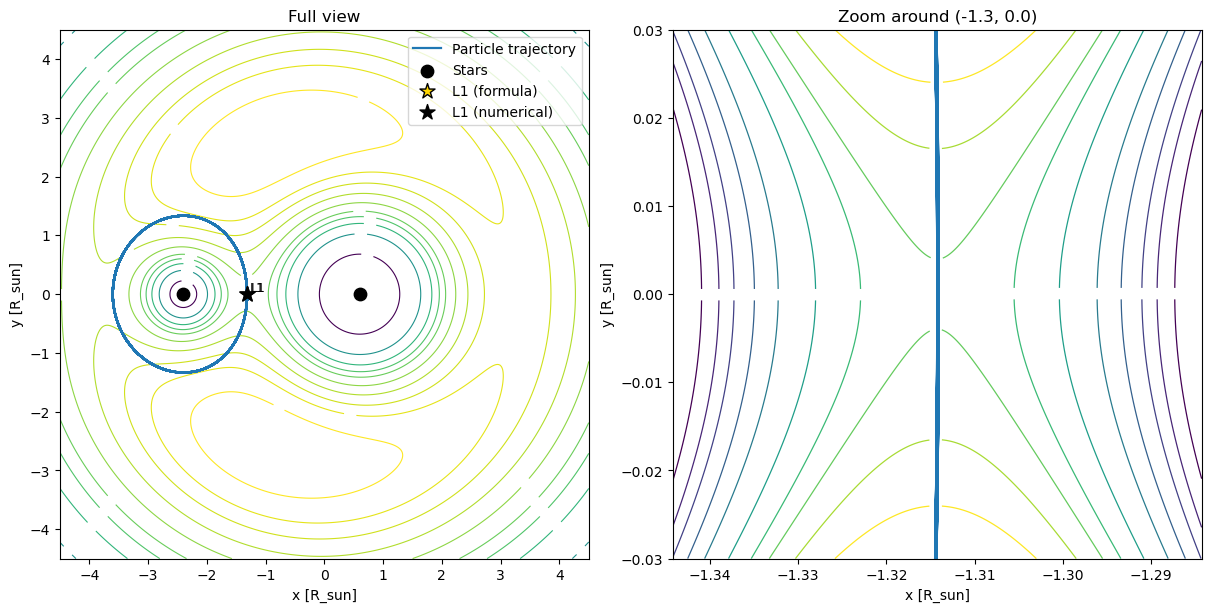

In [68]:
#region ----- Setup ------

# ----- Constants ------
G = 6.67430e-11          # [m^3 kg^-1 s^-2] gravitational constant
M_sun = 1.98847e30       # [kg] solar mass
R_sun = 6.957e8          # [m] solar radius

# ----- Model Parameters -----
M_c = 1.4 * M_sun        # [kg] accretor (e.g., neutron star)
M_s = 0.35 * M_sun       # [kg] donor star
a   = 3 * R_sun          # [m] separation between object centers

# ----- Positions of Stars in (Barycentric) Coordinate System -----

x_c =  a * M_s / (M_c + M_s)    # [m] accretor on right
y_c = 0.0                       # [m]
x_s = -a * M_c / (M_c + M_s)    # [m] donor on left
y_s = 0.0                       # [m]

r_c = np.array([x_c, y_c], dtype=float) # accretor position
r_s = np.array([x_s, y_s], dtype=float) # donor position  

# ----- Binary orbital angular speed -----
Omega = np.sqrt(G * (M_c + M_s) / a**3)    # [rad/s]
Period = 2.0 * np.pi / Omega               # [s] orbital period

#endregion

#region ------ Dynamics Functions ------

def accel_xy(x, y, vx, vy):

    """
    Provided the position (x,y) and velocity (vx,vy) of a test particle in the
    rotating frame, this function return the acceleration (ax,ay) in that frame.
    a = gravity(M_c) + gravity(M_s) + centrifugal + coriolis
    """
    
    # Dispacement components from stars to particle
    dx_c = x - r_c[0]
    dy_c = y - r_c[1]
    dx_s = x - r_s[0]
    dy_s = y - r_s[1]

    # Distances squared
    rc2 = dx_c*dx_c + dy_c*dy_c
    rs2 = dx_s*dx_s + dy_s*dy_s

    # Distances |r|^3
    rc32 = rc2 * np.sqrt(rc2)
    rs32 = rs2 * np.sqrt(rs2)

    # Gravity (per unit mass)
    ax_g = -G * M_c * dx_c / rc32 - G * M_s * dx_s / rs32
    ay_g = -G * M_c * dy_c / rc32 - G * M_s * dy_s / rs32

    # Centrifugal (about CM at origin)
    ax_cent = Omega * Omega * x
    ay_cent = Omega * Omega * y

    # Coriolis
    ax_cor =  2.0 * Omega * vy
    ay_cor = -2.0 * Omega * vx

    # Acceleration components
    ax = ax_g + ax_cent + ax_cor
    ay = ay_g + ay_cent + ay_cor
    
    return ax, ay

def time_derivative(state):
    """
    Returns the time derivatives [dx/dt, dy/dt, dvx/dt, dvy/dt]
    for a particle in the rotating frame, given its current state.
    
    state = [x, y, vx, vy]
    """
    # Unpack state vector
    x, y, vx, vy = state
    
    # Compute accelerations from forces
    ax, ay = accel_xy(x, y, vx, vy)
    
    # Return the derivative of the state
    return np.array([vx, vy, ax, ay], dtype=float)

def rk4_step(state, dt):
    """
    Perform a single 4th-order Runge–Kutta integration step.
    
    state = [x, y, vx, vy]
    dt    = timestep
    """
    # Evaluate intermediate slopes
    k1 = time_derivative(state)
    k2 = time_derivative(state + 0.5 * dt * k1)
    k3 = time_derivative(state + 0.5 * dt * k2)
    k4 = time_derivative(state + dt * k3)
    
    # Return the updated state (fourth-order accurate)
    new_state = state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return new_state
#endregion

#region ----- Fizix Functions -----

def roche_potential(x, y, eps=1e2):
    
    # Dispacement components from stars to particle
    dx_c = x - r_c[0]
    dy_c = y - r_c[1]
    dx_s = x - r_s[0]
    dy_s = y - r_s[1]

    # Distances with softening to avoid singularities
    rc = np.sqrt(dx_c*dx_c + dy_c*dy_c + eps*eps)
    rs = np.sqrt(dx_s*dx_s + dy_s*dy_s + eps*eps)

    # Roche potential
    roche_potential = -G*M_c/rc - G*M_s/rs - 0.5 * (Omega**2) * (x*x + y*y)
    
    return roche_potential

def l1_from_formula(x_c, x_s, a, M_c, M_s, use_log10=True):
    q = M_c / M_s                          # (donor / compact)
    logq = np.log10(q) if use_log10 else np.log(q)
    b1 = a * (0.500 + 0.227 * logq)        # distance from compact star to L1
    # put L1 along the line from compact star toward the donor
    dir_sign = np.sign(x_s - x_c)          # +1 if donor to the right, -1 if to the left
    x_L1 = x_c + dir_sign * b1
    y_L1 = 0.0                             # your stars lie on y=0
    return x_L1, y_L1

def dPhi_dx(x, eps=1e2):
    """Derivative of Roche potential along x-axis (y=0)."""
    dx_c = x - r_c[0]
    dx_s = x - r_s[0]
    rc3 = (dx_c**2 + eps**2)**1.5
    rs3 = (dx_s**2 + eps**2)**1.5
    # derivative of effective potential wrt x
    return G*M_c*dx_c/rc3 + G*M_s*dx_s/rs3 - Omega**2 * x
#endregion

# Mark L1 point (from formula) AND then from numerical root finding
x_L1f, y_L1f = l1_from_formula(x_c, x_s, a, M_c, M_s, use_log10=True)
x_L1n, y_L1n = brentq(dPhi_dx, r_c[0], r_s[0]), 0

# ----- Initial Conditions -----

# x0 = x_c - 0.93 * a     # [m]                                          *******************************************************************
x0 = x_L1n              # [m]                                           *******************************************************************
y0 = 0.0                # [m]
vx0 = 0.0               # [m/s]
vy0 = -4.143e5          # [m/s]                                         *******************************************************************

state0 = np.array([x0, y0, vx0, vy0], dtype=float)

# ----- Integration Controls -----

dt = 2             # [s] #                                              *******************************************************************
Nsteps = int(2.8e5)  # total steps #                                    *******************************************************************
only_1_orbit = False

#region ----- Integrator -----

traj = np.empty((Nsteps, 4), dtype=float) # to store trajectory
state = state0.copy()
crossed_x_axis = 0
prev_y_sgn = np.sign(state[1])

cross_coords = []

i = 0
while i < Nsteps:
    
    traj[i] = state
    cur_y_sgn = np.sign(state[1])

    # Stop if particle gets too close to accretor
    dx, dy = state[0] - x_c, state[1] - y_c
    if np.hypot(dx, dy) < 0.04 * a: # [m] Radius threshold
        traj = traj[:i+1]
        break
    if only_1_orbit:
        if prev_y_sgn != cur_y_sgn:
            crossed_x_axis += 1
            cross_coords.append(state)
        if crossed_x_axis >= 3:
            break

    state = rk4_step(state, dt)
    prev_y_sgn = cur_y_sgn
    i += 1

if i < Nsteps:
    traj = traj[:i]

x_traj, y_traj, vx_traj, vy_traj = traj.T
#endregion

#region ----- Plotting -----

# Grid
size = 3 * a
nx = ny = 400
xs = np.linspace(-size*0.5, size*0.5, nx)
ys = np.linspace(-size*0.5, size*0.5, ny)
XX, YY = np.meshgrid(xs, ys)

# Plotting equipotentials
Phi_grid = roche_potential(XX, YY)
levels_full = np.quantile(Phi_grid, [0.02, 0.05, 0.10, 0.15, 0.20, 0.30, 0.45, 0.60, 0.75, 0.90])

# Grid for zoomed view
zoom_x_cent = x0 # x_traj[-1]
zoom_y_cent = y0 # y_traj[-1]
zoom = 0.01 * a  #                                           *******************************************************************
displacement = 0.0 * a #                                    *******************************************************************
nxz = nyz = 500
xsz = np.linspace(zoom_x_cent + displacement - zoom, zoom_x_cent + displacement + zoom, nxz)
# xsz = np.linspace(x_c + displacement - zoom, x_c + displacement + zoom, nxz)
ysz = np.linspace(zoom_y_cent - zoom, zoom_y_cent + zoom, nyz)
# ysz = np.linspace(y_c - zoom, y_c + zoom, nyz)
XXz, YYz = np.meshgrid(xsz, ysz)

# Plotting equipotentials in zoomed view
Phi_grid_z = roche_potential(XXz, YYz)
levels_zoom = np.quantile(Phi_grid_z, [0.05, 0.10, 0.15, 0.22, 0.30, 0.42, 0.55, 0.70, 0.85, 0.95])

# Make Figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Left: full view
cs1 = ax1.contour(XX/R_sun, YY/R_sun, Phi_grid, levels=levels_full, linewidths=0.8)
ax1.clabel(cs1, inline=True, fontsize=7, fmt="")
ax1.plot(x_traj/R_sun, y_traj/R_sun, lw=1.6, label='Particle trajectory')
ax1.scatter([x_c/R_sun, x_s/R_sun], [y_c/R_sun, y_s/R_sun], s=80, c='k', marker='o', label='Stars')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x [R_sun]')
ax1.set_ylabel('y [R_sun]')
ax1.set_title('Full view')
ax1.legend(loc='upper right', frameon=True)
ax1.set_xlim(-size*0.5/R_sun, size*0.5/R_sun)
ax1.set_ylim(-size*0.5/R_sun, size*0.5/R_sun)

ax1.scatter(x_L1f/R_sun, y_L1f/R_sun, s=130, c='gold', marker='*', edgecolor='k', zorder=5, label='L1 (formula)')
ax1.text(x_L1f/R_sun + 0.05, y_L1f/R_sun + 0.05, 'L1', color='k', fontsize=9)
ax1.legend(loc='upper right', frameon=True)

ax1.scatter(x_L1n/R_sun, y_L1n/R_sun, s=130, c='black', marker='*', edgecolor='k', zorder=5, label='L1 (numerical)')
ax1.text(x_L1n/R_sun + 0.05, y_L1n/R_sun + 0.05, 'L1', color='k', fontsize=9)
ax1.legend(loc='upper right', frameon=True)

# Right: zoom on accretor
cs2 = ax2.contour(XXz/R_sun, YYz/R_sun, Phi_grid_z, levels=levels_zoom, linewidths=0.9)
ax2.clabel(cs2, inline=True, fontsize=7, fmt="")
ax2.plot(x_traj/R_sun, y_traj/R_sun, lw=1.6)
ax2.scatter([x_c/R_sun], [y_c/R_sun], s=90, c='k', marker='o')
ax2.set_aspect('equal', 'box')
ax2.set_xlabel('x [R_sun]')
ax2.set_ylabel('y [R_sun]')
# ax2.set_title('Zoom around accretor')
ax2.set_title(f'Zoom around ({zoom_x_cent/R_sun:.1f}, {zoom_y_cent/R_sun:.1f})')
# x_center = x_c + displacement
x_center = zoom_x_cent + displacement
ax2.set_xlim((x_center - zoom)/R_sun, (x_center + zoom)/R_sun)
ax2.set_ylim((y_c - zoom)/R_sun, (y_c + zoom)/R_sun)

if only_1_orbit:
    cross_coords_plt = np.array(cross_coords)[:,:2] / R_sun
    ax1.scatter(cross_coords_plt[:,0], cross_coords_plt[:,1], s=50, c="purple")
    ax2.scatter(cross_coords_plt[:,0], cross_coords_plt[:,1], s=10, c="purple")
plt.show()
#endregion


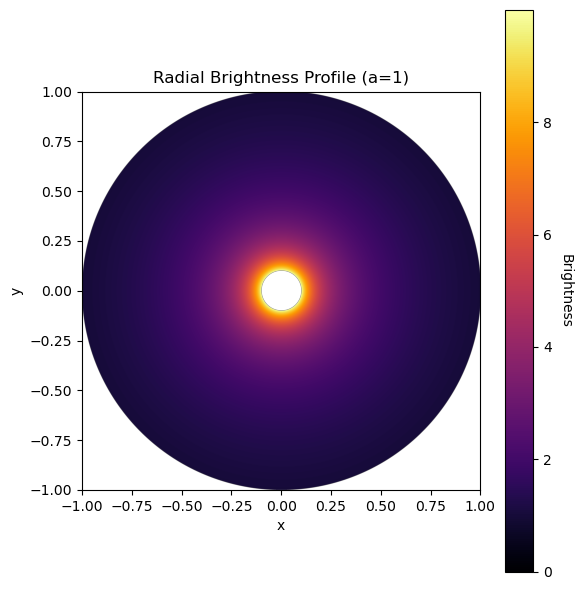

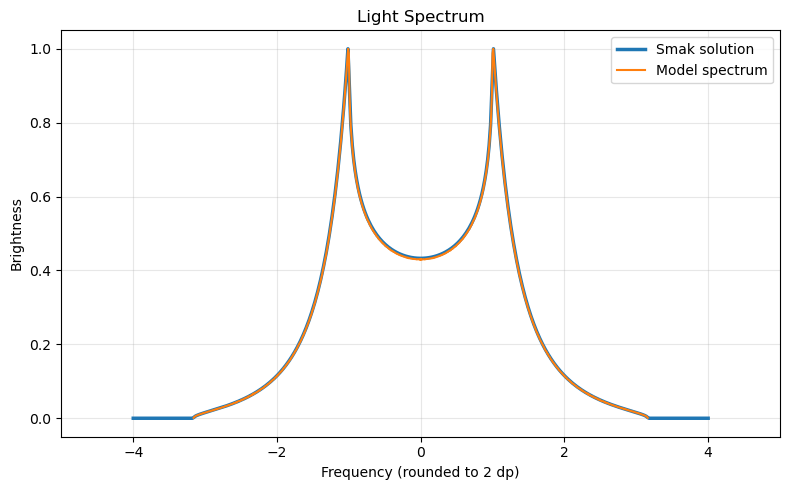

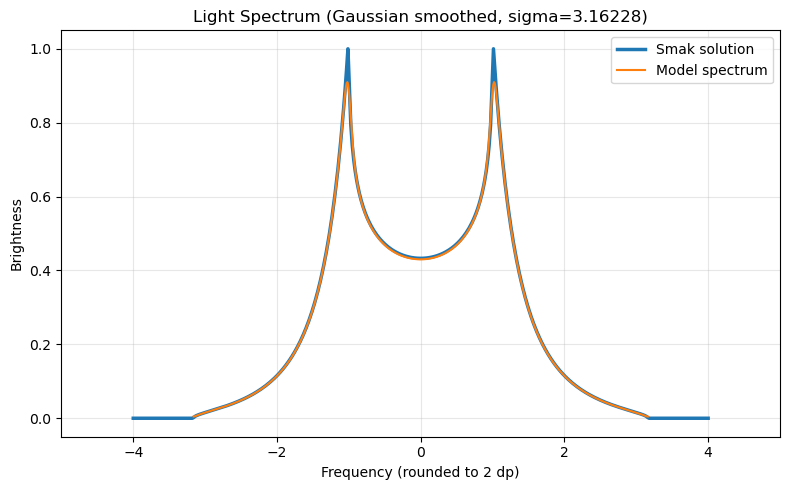

In [27]:
# Accretion Disc Spectrum Model

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ----- INITIALISE -----
Rmax = 1
Rmin = 0.1
N = 5000
eps = 1e-12

coords = np.linspace(-Rmax, Rmax, N)     # 1D coordinate vector
X, Y = np.meshgrid(coords, coords)       # 2D grid
R = np.hypot(X, Y)                       # distances from origin
theta = np.arctan2(Y, X)                 # angles from origin
mask = (R >= Rmin) & (R <= Rmax)         # points within the disc
extent = [-Rmax, Rmax, -Rmax, Rmax]      # CHAT - imshow extent for plotting
# a = [0, 0.5, 1, 1.5, 2, 2.5]
a = 1

# ----- PROFILE FUNCTION -----
def profile2d(func, R, theta, mask,
              eps=1e-15,
              plot=False,
              colourmap="viridis",
              vmin=None, vmax=None,
              title="Profile",
              x_label="x", y_label="y",
              colour_bar_name="Value",
              extent=None,
              ax=None,
              symmetric=False,   # set symmetric color limits around 0 (for signed fields)
              nonneg=False       # force vmin=0 and vmax=max (for non-negative fields)
              ):
    """
    Compute a 2D profile from func(r, theta) on the masked domain, optionally plot it.
    """
    # Compute values
    values = np.full_like(R, np.nan, dtype=float)
    values[mask] = func(np.maximum(R[mask], eps), theta[mask])

    # Handle extent - CHAT
    if extent is None:
        # Fallback: infer square extent from max radius in mask
        rmax = np.nanmax(R[mask])
        extent = [-rmax, rmax, -rmax, rmax]

    # Auto color scaling helpers - CHAT
    if symmetric:
        vmax_auto = np.nanmax(np.abs(values))
        vmin_plot = -vmax_auto if vmin is None else vmin
        vmax_plot =  vmax_auto if vmax is None else vmax
    elif nonneg:
        vmin_plot = 0.0 if vmin is None else vmin
        vmax_plot = np.nanmax(values) if vmax is None else vmax
    else:
        vmin_plot = vmin
        vmax_plot = vmax

    # Optional plotting
    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
        else:
            fig = ax.figure

        img = ax.imshow(
            values,
            extent=extent,
            origin="lower",
            cmap=colourmap,
            aspect="equal",
            vmin=vmin_plot, vmax=vmax_plot
        )
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label(colour_bar_name, rotation=270, labelpad=15)

        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        plt.tight_layout()
        plt.show()

    return values

# ----- CREATE PROFILES -----

# Velocity-like profile: cos(t)/sqrt(r), signed -> use symmetric=True
velocity = profile2d(
    lambda r, t: np.cos(t) / np.sqrt(r),
    R, theta, mask,
    eps=eps,
    plot=0,
    colourmap="seismic",
    title="Doppler Shift",
    colour_bar_name="Velocity",
    extent=extent,
    symmetric=True
)

# Radial Brightness profile: r^(-a), non-negative -> use nonneg=True

brightnessrad = profile2d(
    lambda r, th: r**(-a),
    R, theta, mask,
    eps=eps,
    plot=1,
    colourmap="inferno",
    title=f"Radial Brightness Profile (a={a})",
    colour_bar_name="Brightness",
    extent=extent,
    nonneg=True
)

# ----- DATA ANALYSIS -----

# Parameters
p = 2  # decimal places
# Extract net freq and brightness
frequency = np.round(velocity, p) # discretise by rounding
brightness = brightnessrad

# Keep valid points
valid = np.isfinite(frequency) & np.isfinite(brightness)
f = frequency[valid]
w = brightness[valid]

# Group by unique rounded frequency and sum brightness
unique_f, inverse = np.unique(f, return_inverse=True)
sum_brightness = np.bincount(inverse, weights=w)
# Result: unique_f (frequencies), sum_brightness (total brightness per frequency)

# Normalise max brightness to to 1
sum_brightness_norm = sum_brightness / np.max(sum_brightness)

# ----- SMAK ANALYTICAL SOLUTION -----

import numpy as np

def I(a, x):
    eps = 1e-12
    y = np.nan
    if abs(x) <= 1.0:
        s = np.sqrt(1.0 - x**2)
        if a == 0.0:
            y = -((x**3)/4.0 + (3.0*x)/8.0) * s + (3.0/8.0) * np.arcsin(x)
        elif a == 0.5:
            y = (1.0/3.0) * (s**3) - s
        elif a == 1.0:
            y = -(x/2.0) * s + 0.5 * np.arcsin(x)
        elif a == 1.5:
            y = -s
        elif a == 2.0:
            y = np.arcsin(x)
        elif a == 2.5:
            y = np.log(abs((1.0 - s) / x)) if abs(x) > eps else np.nan
        else:
            raise NotImplementedError("Only a ∈ {0,0.5,1,1.5,2,2.5} supported.")
    return y

def I_difference(a, u, Rmin):
    x_z = np.clip(u, -1.0, 1.0)
    x_1 = np.clip(u*np.sqrt(Rmin), -1.0, 1.0)
    return I(a, x_z) - I(a, x_1)

Smak_u = np.linspace(-4.0, 4.0, 400)          # x_plotting
Smak_F = np.full_like(Smak_u, np.nan, float)   # y_plotting

exp = 2*a - 5
rootR = np.sqrt(Rmin)

for i, u in enumerate(Smak_u):
    # guard the singular prefactor at u=0 if exponent < 0
    if abs(u) < 1e-12 and exp < 0:
        Smak_F[i] = np.nan
        continue

    x_z = np.clip(u, -1.0, 1.0)
    x_1 = np.clip(u*rootR, -1.0, 1.0)

    upper = I(a, x_z)
    lower = I(a, x_1)
    diff  = upper - lower

    Smak_F[i] = (u**exp) * diff

# normalise robustly (optional)
finite = np.isfinite(Smak_F)
if finite.any():
    amp = np.nanmax(np.abs(Smak_F))
    Smak_F_norm = Smak_F / amp if (np.isfinite(amp) and amp > 0) else Smak_F
else:
    Smak_F_norm = Smak_F

# ----- PLOT SPECTRUM -----

def plot_spectrum(unique_f,
                  sum_brightness_norm,
                  Smak_u=None,
                  Smak_F_norm=None,
                  *,
                  p=2,
                  xlim=(-5, 5),
                  Smak=False,
                  sigma=None,
                  xlabel="Frequency",
                  ylabel="Brightness",
                  title="Light Spectrum",
                  figsize=(8, 5),
                  grid_alpha=0.3):

    # Make safe copies
    x = np.asarray(unique_f)
    y = np.asarray(sum_brightness_norm)

    # Optional gaussian smoothing
    if sigma is not None and sigma > 0:
        if gaussian_filter1d is None:
            raise RuntimeError("gaussian_filter1d not available; install SciPy or remove smoothing.")
        y = gaussian_filter1d(y, sigma=sigma)
        title = f"{title} (Gaussian smoothed, sigma={sigma:g})"

    # Plot
    plt.figure(figsize=figsize)

    if Smak:
        if Smak_u is None or Smak_F_norm is None:
            raise ValueError("Smak=True but Smak_u/Smak_F_norm not provided.")
        plt.plot(Smak_u, Smak_F_norm, linestyle='-', linewidth=2.5, label='Smak solution')
        plt.plot(x, y, linestyle='-', label='Model spectrum')
        plt.legend()
    else:
        plt.plot(x, y, linestyle='-')

    plt.xlabel(f"{xlabel} (rounded to {p} dp)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=grid_alpha)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.tight_layout()
    plt.show()

# Raw spectrum (no smoothing)
plot_spectrum(
    unique_f, sum_brightness_norm,
    Smak_u=Smak_u, Smak_F_norm=Smak_F_norm,
    p=p, sigma=None, Smak=True, title="Light Spectrum"
)

# Smoothed spectrum
plot_spectrum(
    unique_f, sum_brightness_norm,
    Smak_u=Smak_u, Smak_F_norm=Smak_F_norm,
    p=p, sigma=(10**(1/p)), Smak=True, title="Light Spectrum"
)
